# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on several
datasets. As part of the practical you should read briefly the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier (NBC)

You should implement a Naïve Bayes Classifier from scartch using NumPy. To keep your code tidy,
we recommend implementing it as a class. 
The classifier should be able to handle binary and continuous features. 
To earn the bonus points, the classifier should be able to handle categorical features as well. 
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function computes the probabilities that the new input belongs to all classes and
then returns the class that has the largest probability, i.e., makes a prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [5]:
import pandas as pd
import scipy.stats
from scipy.stats import multinomial
from scipy.stats import bernoulli
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np


### Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. Your implementation should have two functions: **estimate** and **get_log_probability**. 

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE). 
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data. 

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma^2)$. 

For different types of features, you need to use different distributions.
You can import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions. 

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html

Example: https://stackoverflow.com/questions/12412895/how-to-calculate-probability-in-a-normal-distribution-given-mean-standard-devi


**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, you should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 / Lecture Notes
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. 
For this practical, please set the small value to 1e-6.
- Laplace/Additive smoothing: You want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
For this practical, please set alpha to 1.
- For simplicity, you can assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.


In [6]:
ALPHA = 1.0 # for additive smoothing
SMALL_VALUE = 1e-6

# Distribution for continuous features
class ContFeatureParam:
    def __init__(self) -> None:
        self.normal_dist = None
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        X_mean = np.mean(X)
        X_std_div = np.std(X)
        # check if variance is 0 and set it to small value 
        if(X_std_div == 0):
            X_std_div = SMALL_VALUE
        #my_normal_dist = 1/(np.sqrt(2*np.pi) * X_std_div) * \
        #    np.exp(-0.5*(((X-X_mean)/X_std_div)**2))
        normal_dist = scipy.stats.norm(X_mean, X_std_div)
        self.normal_dist = normal_dist
        
        return self

    def get_log_probability(self, X_new):
        # TODO: return the log of the density values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        if self.normal_dist:
            return self.normal_dist.logpdf(X_new)
        else: 
            raise Exception("Please run the estimate function first")

# Distribution for binary features
class BinFeatureParam:
    def __init__(self) -> None:
        self.p1 = None
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        # X is a vector with binary values X = np.array([0,0,1,1,0,1,0,1,1,1])
        count_ones = np.count_nonzero(X==1)
        array_size = X.size
        # without Laplace smoothing
        #p1 = count_ones/array_size
        
        #Laplace smoothing
        p1 = (count_ones + ALPHA)/(array_size + 2*ALPHA)
        self.p1 = p1
        return self

    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # convert X_new to float to accept the probability
        #print(bernoulli.logpmf(X_new,self.p1))
        X_new = X_new.astype(np.float32)
        if(self.p1):
            #X_new[X_new == 1] = self.p1
            #X_new[X_new == 0] = 1 - self.p1
            #return np.log(X_new)
            return bernoulli.logpmf(X_new, self.p1, loc=0)
        else:
            raise Exception("Please run the estimate function first")



# Distribution for categorical features
class CatFeatureParam:
    
    # we need to know the number of categories for the categorical feature
    def __init__(self, num_of_categories):
        self._num_of_categories = num_of_categories
        self.prob = None
        self.rv = None
    
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution
        # so that it best describes the input data X
        
        prob = {}
        # initialize our dict 
        for i in range(self._num_of_categories):
            prob.update({i: 0})
            
        unique, counts = np.unique(X, return_counts=True)
        # without laplace 
        #counts = counts / X.size

        prob.update(dict(zip(unique, counts)))
        # Laplace smoothing
        for key, val in prob.items():
            prob[key] = (val + ALPHA)/(self._num_of_categories*ALPHA + X.size)
            
        #print(sum(prob.values()))
        assert int(sum(prob.values())) == 1
       
            
        #print(prob)
        self.prob = prob
       
        
        return self


    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        if self.prob:
            return np.log(np.array([self.prob.get(key) for key in X_new]))


**Tests:**
    
We will use the code below to test the correctness of your code.

In [7]:
# continuous features

X = np.array([2.70508547,2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3]))
print(probs)

[-5.64670664 -3.02757918 -1.44567455 -0.90099277]


In [8]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])



param = BinFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-0.87546874 -0.5389965 ]


In [9]:
# categorical features (bonus task)

X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])
param = CatFeatureParam(max(X)+1)
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[-1.94591015 -2.1690537  -1.94591015 -2.45673577 -2.1690537  -2.86220088
 -1.94591015 -3.55534806 -2.1690537  -2.86220088]


### Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data. 

**Implementation Issues:**
- You should use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues, you should do the calculations in log space. Read more: (Mur) Chapter 3.5.3 / Lecture Note
- For simplicity, you can assume the data values for binary features are integers from {0, 1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.

In [10]:
# Your task is to implement the three functions of NBC. 

class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    def __init__(self, feature_types=[]):
        self.feature_types = feature_types
        # make sure at least 1 feature type is passed
        assert len(self.feature_types) >=1
        self.class_prior = None
        self.estimation_all_classes = {}
        self.unique_classes = []
     

    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        # compute class prior
        # get count of unique classes
        unique_classes, counts = np.unique(y, return_counts=True)
        self.unique_classes = unique_classes
        # compute appearance of each class in the data
        counts = counts / y.size
        self.class_prior = dict(zip(unique_classes,counts))
        #print(self.class_prior)
        
        # Estimate a parameter 𝜃𝑗𝑐 for each class 𝑐 and each feature 𝑗
        for c in self.unique_classes:
            estimations_c = []
            for j in range(len(self.feature_types)):
                # get each column (feature) of class c 
                column_j_c = X[y == c][:, j]
                
                # estimate each column and add to array
                
                # choose prober estimator
                if (self.feature_types[j] == 'r'):
                    estimations_c.append(ContFeatureParam().estimate(column_j_c))
                elif (self.feature_types[j] == 'b'):
                    estimations_c.append(
                        BinFeatureParam().estimate(column_j_c))
                elif (self.feature_types[j] == 'c'):
                    estimations_c.append(
                        CatFeatureParam(max(column_j_c)+1).estimate(column_j_c))

            # add estimation of class c to our main estimation array
            self.estimation_all_classes.update({c:estimations_c})
        
        #print(self.estimation_all_classes)
        return self
                
       
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        # for predict we just take the 𝑝(𝑦 = 𝑐|𝝅)=𝜋c
        df = pd.DataFrame()
        loc_for_df = 0
        for c in self.unique_classes:
            pi_c = self.class_prior[c]
            prob_c = np.ones(shape=(X.shape))
            #print(prob_c.shape)
            for j in range(len(self.feature_types)):
                column_j = X[:, j]
                prob_c[:,j] = self.estimation_all_classes[c][j].get_log_probability(column_j)
            df.insert(loc_for_df, c,(np.sum(prob_c, axis=1) + np.log(pi_c)))
            loc_for_df+=1
        df["prediction"] = df.idxmax(axis=1)
        #display(df)
        return df["prediction"]


            


**Tests**

We will use the code below to check your code.

In [11]:
# All features of the iris dataset are continuous.
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

df = pd.DataFrame(data=X)
df.insert(4,4, y)
# displaying the dataframe
#display(df)

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)
print("Accuracy:", test_accuracy) # should be larger than 90%
#print(yhat)

Accuracy: 0.9333333333333333


In [12]:
# All features of this dataset are binary
import pandas as pd
data = pd.read_csv('./datasets/binary_test.csv', header=None)
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]
df = pd.DataFrame(data=X)
df.insert(16, 16, y)

#display(df)
N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['b'] * 16)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)

test_accuracy = np.mean(yhat == ytest)
#print(ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%
#print(yhat)

Accuracy: 0.8723404255319149


In [13]:
# All features of this dataset are categorical (bonus task)

data = pd.read_csv('./datasets/categorical_test.csv', header=None)
data = data.to_numpy()

#print(data.shape)
X = data[:,:-1]
y = data[:,-1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['c'] * 9)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)
#print(ytest)

print("Accuracy:", test_accuracy) # should be larger than 65%
#print(yhat) 

Accuracy: 0.6896551724137931


## Logistic Regression

For logistic regression (LR), you should use the implementation in scikit-learn. Add the following
line to import the LR model.

In [14]:
from sklearn.linear_model import LogisticRegression

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets. 
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a function of the size of the training data. 
We have written for you the function for making the plots for the experiments. 

Check the scikit-learn documentation for the Logistic Regression model:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


In [20]:
np.random.seed(42)

def shuffleData(X,y):
    N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    print(shuffler)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]  
    return Xtrain, ytrain, Xtest, ytest

shuffleData(X,y)

    

[219  66   9 170  15 201  25 197 154 126 216  19  96 178 175 137 146  30
 227 185 108 162 206 181 125  18 147 101 104  84 199  60 118  45  16 127
 159 119  82 144  93 195 143  73 113 112 150  55 230  69 168 109 124  79
  86  95 215 117  38  24  67 186 200  10 120  29 153  68  75   5  56 114
 139 194  65 142 196 136  31  12  35  28  42 229 115 155  51 132 183  76
  41  97 140  78 135  26 213 172 158   0   2  77  46 100 111 138 165  90
  85 161 152  98  36 182  61  22 211 184  33  11 226 180   6  27 141 222
 223 156   4 122  32 164  62 128 208 173  70 176  64  44 148  40 123  23
 171 167  81  39 193  47  94 190  43 145 207   3 105  53 133 209 177 220
  49 163  80  34   7 110  91  83 205 221  89   8  13  59 198 131  17 166
  72 218 134 225 212  63  54 107  50 204 174 192 189 228 203 169  58  48
  88  21  57 160 224 187 191 129  37 157 217   1  52 149 130 151 103  99
 116  87 202  74 214 210 121 231  20 188  71 106  14  92 179 102]


(array([[1., 1., 1., ..., 0., 0., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        [0., 1., 0., ..., 1., 0., 0.],
        ...,
        [1., 0., 1., ..., 0., 0., 1.],
        [0., 1., 1., ..., 0., 1., 1.],
        [0., 0., 0., ..., 1., 0., 1.]]),
 array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 1], dtype=int64),
 array([[0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1.],
        [1., 1., 1., 0., 0., 0., 0.

## Comparing NBC and LR

In [16]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
    N, D = X.shape
    tst_errs_nbc = np.zeros(num_splits)
    tst_errs_lr = np.zeros(num_splits)
    
    #print(tst_errs_lr, tst_errs_nbc)

    in_percent = num_splits/100

    for i in range(num_runs):
        # shuffle the data 200 times 
        Xtrain, ytrain, Xtest, ytest = shuffleData(X,y)   
               
        for i in range(num_splits):
            split = int(((i/10)+in_percent) * Ntrain)
            #print(split)
            Xtrain_split = Xtrain[:split]
            ytrain_split = ytrain[:split]
            

            # Log.Reg.
            lr.fit(Xtrain_split, ytrain_split)
            yhat = lr.predict(Xtest)
            test_accuracy = np.mean(yhat == ytest)
            tst_errs_lr[i] += (1-test_accuracy)
            
            nbc.fit(Xtrain_split, ytrain_split)
            yhat = nbc.predict(Xtest)
            test_accuracy = np.mean(yhat == ytest)
            tst_errs_nbc[i] += (1-test_accuracy)
                

        
    print(tst_errs_nbc)
    print(tst_errs_lr)


        # break
    tst_errs_nbc = tst_errs_nbc / num_runs
    tst_errs_lr = tst_errs_lr / num_runs
        

    return tst_errs_nbc, tst_errs_lr


In [17]:
def makePlot(tst_errs_nbc, tst_errs_lr, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, tst_errs_nbc, label='Naive Bayes')
    plt.plot(xaxis_scale, tst_errs_lr, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers, e.g., handle missing values, handle text/categorical data, etc.
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

[ 54  71 117  30  58  81  10  64  51  28 130 138  70 139  80 123 122  55
  76  39  73  78 120   9 113 149  88  61 136  74   2  40 112 116  75 119
   4  87  77 106 102 109  72  97  83  69 137  89 100  79  33 147  14  82
 142  11  13  15 101 133   0  19  44  35  56   6  99  12  85  90  49  25
  41  38 121  42   8  93 115   1 131  65  22  46  95 105 103 107  57  53
  24  17  66 140  86  31  84  62 124  59 143  94  52 126 111  23  36 104
  98   5  45  92 129  91  43  16  48 125  34   3  18 145  60  68 128  63
 110  27  96  29 146 132  26   7  50 108  37  21 118 114 148 144 134 135
 127  47  20 141  32  67]
[ 51 101 131 129 106 121 141 105  37 123  26 132  82 142 120  56  87  59
   5  75  77  78 148 104  14  17 145  10  69   2  41 122  44  96 102  65
  53  92  58 116  97   4 128 111  30  13  27 144   8  52  55  40 130  88
  62  18 107  21  24  47  19  70 119  16  29  71 134  54  98  36  61 137
  76 126  48  63 125  72 136  81  20  35 109  74  57  67   6 133 103  25
   7  89  80  86 115 124 

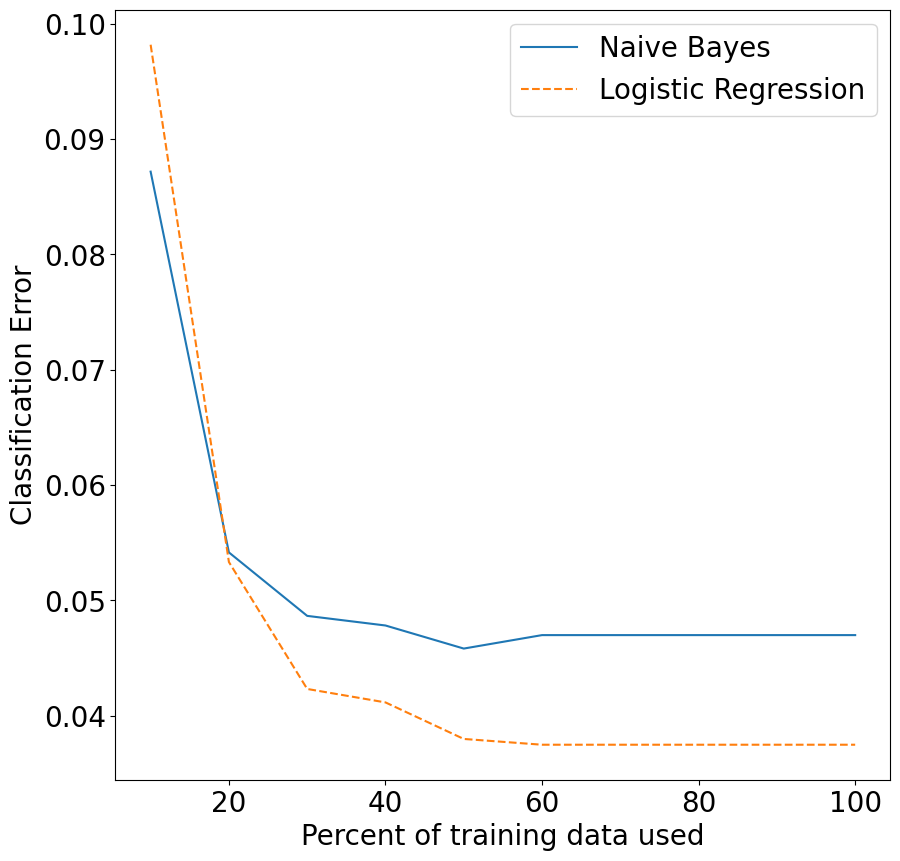

In [18]:

# to hide warnings
import warnings
warnings.filterwarnings("ignore")  
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB, BernoulliNB

iris = load_iris()

X, y = iris['data'], iris['target']

nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
lr = LogisticRegression()
gnb = GaussianNB()


results = compareNBCvsLR(nbc_iris, lr, X, y)
makePlot(results[0], results[1])


**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot. To see it clearer, you should use only 100 data points from the dataset for this experiment.

[69 51 20 82 75 15 49 17 30 91 60 19 41 57 37 16 67  5 24  9  1 55 18 65
 85 66 76 42 50 68 97 45 29  3 35 31 12 83 56 93 80 63 38 48 88 98 90  2
 13 46 87 53 92 58 26 21 94 43 73 36 89 95 22 54 47 72 33 11  6 27 96  4
 32 74 34 78 10 62  7  0  8 70 64 44 99 28 40 59 25 23 52 81 79 84 39 61
 86 77 71 14]
[40 20 13 29  7 73 49  3 92 14 95 12 91 42 83 64 59 81 60 34 70 62 39 30
 48 84 41  9 22 44 80 24 27 65 72 17 63  6 66 45 68 46 25 96 35 19 88 28
 97 56 94 32 15 47 10 21  5 33 82  4 89 37 16 99 77 54 67 86 90 52 74 18
  0 53 75 79 87 55 98  1 38 11 85 57 93 51 31 58 78 23 43 50 36 61  8 26
 71 69  2 76]
[63 11 56 84 99 15 39 64 12 54 77 44 10  8  0 42 68 96 51  1 14 55 82 76
 38 25 71  9 95 93  2 69 41 22 31 62 57 49 30 72 23 36 86 52  5 45 28 61
 59 43 75 48 89  3 18 73  4 87 46 27 74 70 94 33 91 26 78 90 50 98 29 21
 58 80 97 16 66  6  7 19 47 20 13 85 67 32 40 60 79 34 53 65 81 17 92 24
 88 83 37 35]
[58 73 94 42 10  1 60 55 87  9 23 47 38  3 99 20 17 30 32 26 95 98 71 72
 63 91 40

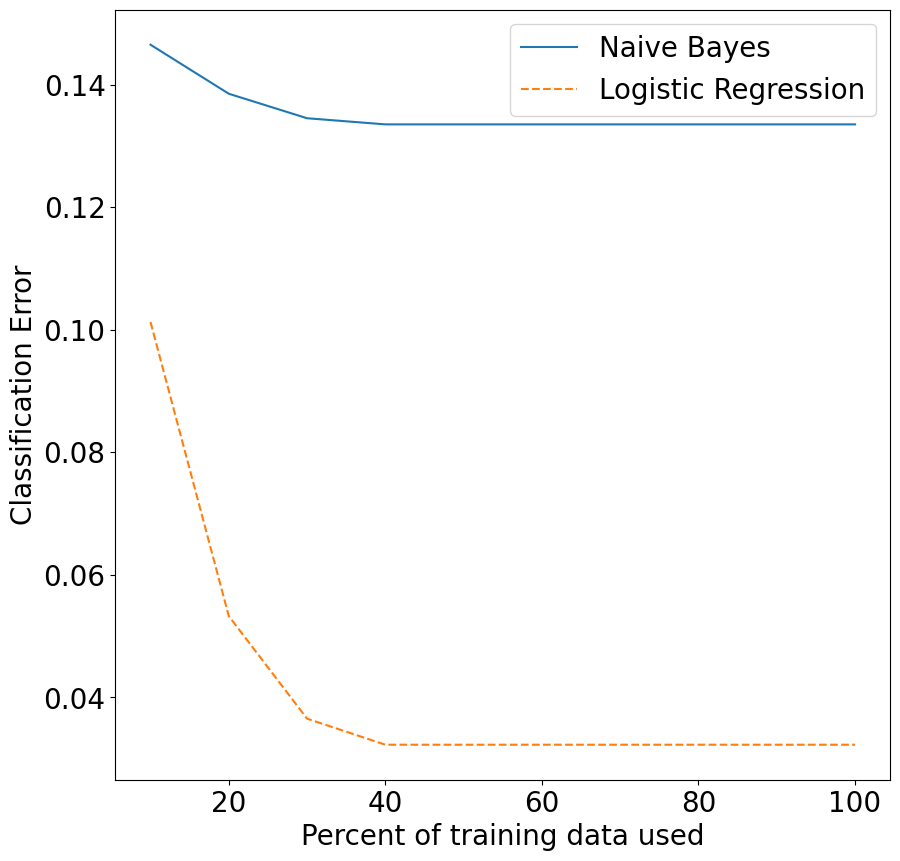

In [19]:
# load the dataset
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
voting = pd.read_csv('./datasets/voting.csv')

#voting.info()

voting.replace('y', 1, inplace=True)
voting.replace('n', 0, inplace=True)
voting.replace('republican', 1, inplace=True)
voting.replace('democrat', 0, inplace=True)


voting = voting.dropna()
#display(voting)

nbc = NBC(feature_types=['b'] * 16)
#nbc = BernoulliNB()
lr = LogisticRegression()

X, y = voting.drop(['label'], axis=1).to_numpy(), voting['label'].to_numpy()
np.random.seed(42)
random_100 = np.random.randint(y.size, size=100)

#print(random_100)


X_100,y_100= X[random_100], y[random_100]


results = compareNBCvsLR(nbc, lr, X_100, y_100)
makePlot(results[0], results[1])